In [1]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

import sys
import os
# 使用当前工作目录
project_root = os.path.dirname(os.getcwd())  # 获取当前目录的父目录
sys.path.insert(0, project_root)
from util.methods import assign_variances

seed = 42
# 定义核函数
kernel = ConstantKernel(25.0) * RBF(length_scale=4.0) + WhiteKernel(1e-3)
gp = GaussianProcessRegressor(kernel=kernel)

x_dense = np.linspace(1, 50, 500).reshape(-1, 1)

y_dense = gp.sample_y(x_dense, n_samples=1, random_state=seed).flatten() + 70

# 提取整数点对应的y值
integer_points = np.arange(1, 51)
y_integers = y_dense[np.linspace(0, 499, 50, dtype=int)]

# 计算整数点的协方差矩阵
cov_matrix = kernel(integer_points.reshape(-1,1))

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)  

np.savetxt('Sigma1.txt', cov_matrix, 
           fmt='%.6f',
           header=f'高斯过程协方差矩阵(1-50整数点)\n核函数: {kernel}')

np.savetxt('correlation_matrix.txt', corr_matrix,
           fmt='%.6f',
           header=f'高斯过程相关性矩阵(1-50整数点)\n核函数: {kernel}')

np.savetxt('mu.txt', 
           y_integers,
           fmt='%.6f',
           header='真实均值')

# 创建分组标签 (5组，每组10个点)
group_labels = np.floor(np.argsort(np.argsort(y_integers))/10).astype(int)
group_names = [f"第{i+1}组" for i in range(5)]  # 组别名称

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_dense.flatten(), 
    y=y_dense,
    mode='lines',
    name='GP曲线',
    line=dict(color='royalblue', width=2)
))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 5种不同颜色
for group in range(5):
    mask = (group_labels == group)
    fig.add_trace(go.Scatter(
        x=integer_points[mask],
        y=y_integers[mask],
        mode='markers',
        name=group_names[group],
        marker=dict(
            color=colors[group],
            size=8,
            line=dict(width=1, color='DarkSlateGrey')
    )))

fig.update_layout(
    title='高斯过程曲线与分组结果',
    xaxis_title='x',
    yaxis_title='f(x)',
    template='plotly_white',
    height=600,
    width=900,
    legend=dict(
        title='组别',
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)'
    ),
    margin=dict(r=150) 
)

fig.show()

In [2]:
eigvals = np.linalg.eigvals(cov_matrix)
print("最小特征值:", np.min(eigvals))
print("负特征值数量:", np.sum(eigvals < 0))

最小特征值: (0.0009999999999915042+0j)
负特征值数量: 0


验证结果:
对角线均值: 1.000000 (目标: 1.0)
最小特征值: 0.000000+0.000000j (应>0)


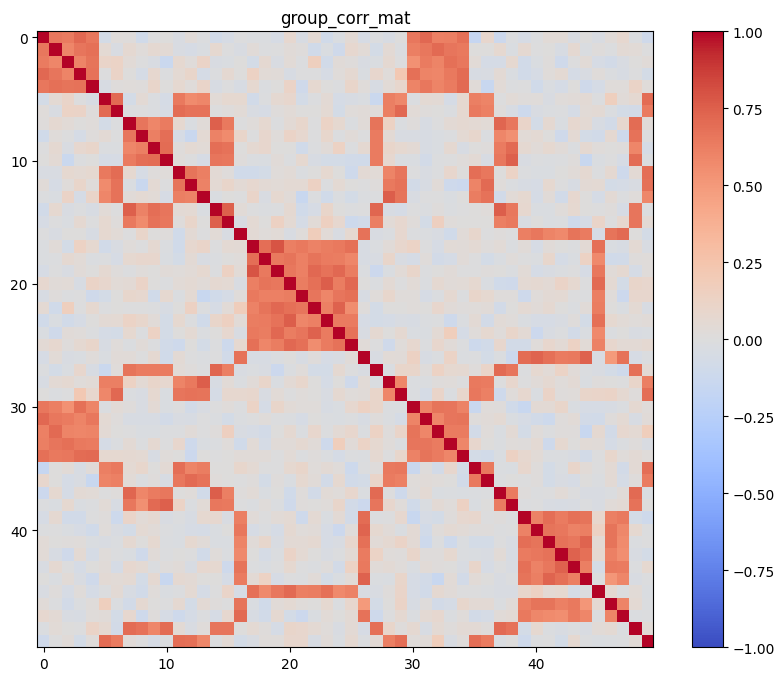

In [3]:
import numpy as np
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

# 初始化参数
n_points = 50
within_group_mean = 0.7
between_group_mean = 0.0
noise_std = 0.1 

np.random.seed(seed=seed)

def build_correlation_matrix(group_labels):
    groups = np.unique(group_labels)
    n_groups = len(groups)
    group_mask = group_labels[:, None] == group_labels  
    
    base_matrix = np.where(group_mask, 
                          within_group_mean, 
                          between_group_mean)
    np.fill_diagonal(base_matrix, 1.0)
    
    random_matrix = np.random.normal(0, noise_std, (n_points, n_points))
    random_matrix = (random_matrix + random_matrix.T) / 2  
    np.fill_diagonal(random_matrix, 0) 
    
    corr_matrix = base_matrix + random_matrix
    

    def project_to_pd(matrix):
        eigvals, eigvecs = np.linalg.eigh(matrix)
        eigvals = np.maximum(eigvals, 1e-8)  
        return eigvecs @ np.diag(eigvals) @ eigvecs.T
    

    for _ in range(10):
        corr_matrix = project_to_pd(corr_matrix)
        # 重新标准化对角线
        diag_scaling = np.diag(1/np.sqrt(np.diag(corr_matrix)))
        corr_matrix = diag_scaling @ corr_matrix @ diag_scaling
    
    return corr_matrix

corr_matrix = build_correlation_matrix(group_labels)

# 验证矩阵性质
print("验证结果:")
print(f"对角线均值: {np.mean(np.diag(corr_matrix)):.6f} (目标: 1.0)")
print(f"最小特征值: {np.min(np.linalg.eigvals(corr_matrix)):.6f} (应>0)")

# 可视化矩阵
plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("group_corr_mat")
plt.show()

In [4]:
# 获取大于1的值的索引
indices = np.where(corr_matrix > 1)
print("大于1的值的索引:", list(zip(indices[0], indices[1])))

# 获取大于1的具体值
values = corr_matrix[corr_matrix > 1]
print("大于1的值:", values)

大于1的值的索引: [(np.int64(1), np.int64(1)), (np.int64(2), np.int64(2)), (np.int64(3), np.int64(3)), (np.int64(6), np.int64(6)), (np.int64(12), np.int64(12)), (np.int64(13), np.int64(13)), (np.int64(14), np.int64(14)), (np.int64(15), np.int64(15)), (np.int64(17), np.int64(17)), (np.int64(18), np.int64(18)), (np.int64(19), np.int64(19)), (np.int64(21), np.int64(21)), (np.int64(22), np.int64(22)), (np.int64(23), np.int64(23)), (np.int64(24), np.int64(24)), (np.int64(25), np.int64(25)), (np.int64(28), np.int64(28)), (np.int64(30), np.int64(30)), (np.int64(31), np.int64(31)), (np.int64(33), np.int64(33)), (np.int64(40), np.int64(40)), (np.int64(41), np.int64(41)), (np.int64(42), np.int64(42)), (np.int64(43), np.int64(43)), (np.int64(44), np.int64(44)), (np.int64(47), np.int64(47)), (np.int64(49), np.int64(49))]
大于1的值: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]


In [5]:
group_labels+1

array([1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 4, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4, 4, 4,
       4, 5, 4, 4, 3, 2])

验证结果:
方差范围: 26.40-134.72 (目标: 25-144)
最小特征值: 0.000000 (应>0)


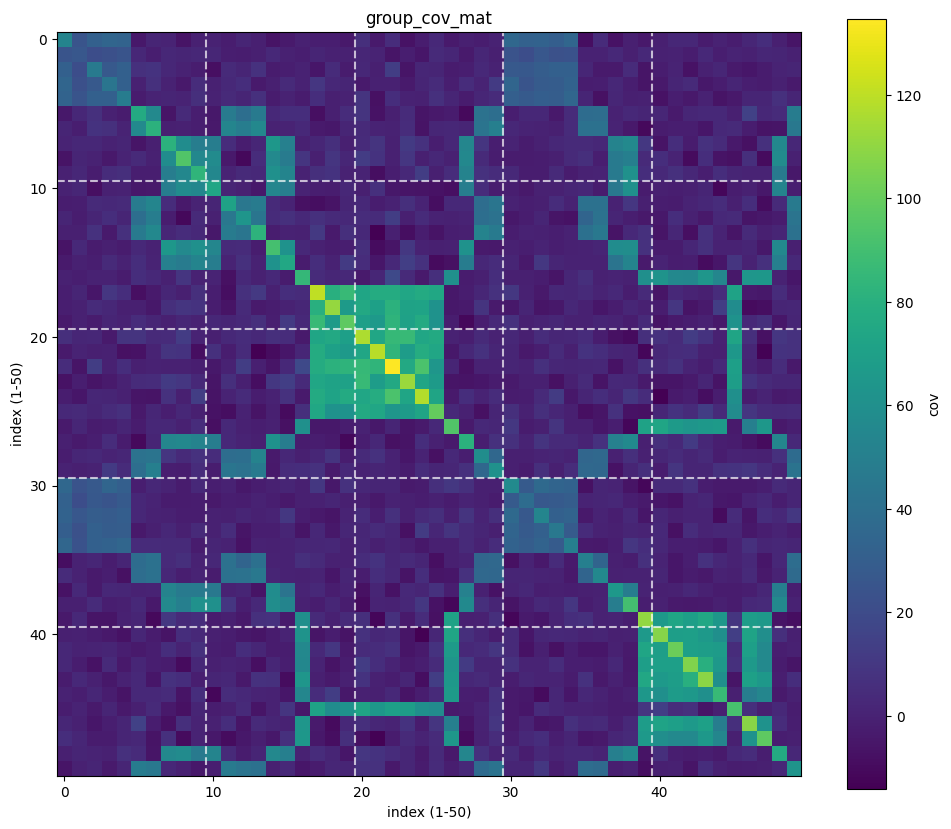

In [6]:
# 随机分配噪声
np.random.seed(seed)  
variances = assign_variances(y_integers, min_var=25, max_var=144, correlation_strength=0.7)
#variances = variances*4
std_devs = np.sqrt(variances)  

D = np.diag(std_devs)

cov_matrix = D @ corr_matrix @ D

print("验证结果:")
print(f"方差范围: {np.min(np.diag(cov_matrix)):.2f}-{np.max(np.diag(cov_matrix)):.2f} (目标: 25-144)")
print(f"最小特征值: {np.min(np.linalg.eigvals(cov_matrix)):.6f} (应>0)")

np.savetxt('group_cov.txt', 
           cov_matrix,
           fmt='%.6f',
           header='协方差矩阵（对角线方差=25-144）\n基于分组相关性矩阵生成')

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.imshow(cov_matrix, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('cov')

for g in range(1,5):
    plt.axhline(y=g*10-0.5, color='white', linestyle='--', alpha=0.7)
    plt.axvline(x=g*10-0.5, color='white', linestyle='--', alpha=0.7)

plt.title('group_cov_mat')
plt.xlabel('index (1-50)')
plt.ylabel('index (1-50)')
plt.show()


In [7]:
y_integers

array([62.64643328, 61.73497361, 61.79594255, 62.64965935, 64.20216509,
       65.89556165, 67.60380585, 68.66089916, 69.07251736, 68.96935928,
       68.37467415, 67.77701386, 67.39880496, 67.57214812, 68.21200846,
       69.25779409, 70.31216556, 71.37766567, 72.11523093, 72.68054   ,
       73.36227003, 74.06931025, 74.58262047, 74.59773666, 74.02803802,
       72.75529193, 70.84513589, 68.54215263, 66.31685099, 64.64136517,
       63.70974155, 63.06385142, 62.79712174, 62.88990109, 63.39331728,
       64.39351225, 65.99525453, 67.91861121, 69.47792943, 70.66227198,
       70.88500785, 70.73853006, 70.53430686, 70.64755521, 70.99363517,
       71.1095309 , 70.93479907, 70.21818347, 69.11033764, 67.40950732])

In [8]:
variances

array([ 52.82107303,  26.4018574 ,  47.09615106,  43.93644498,
        48.30161331,  76.87369795,  81.60856652,  81.52547487,
        94.56133442,  83.38158507,  74.14145727,  71.82568833,
        63.40931788,  82.36975154,  91.10271291,  75.09985793,
        84.79900265, 120.63732281, 111.31232544,  97.98027405,
       116.28561696, 118.78480831, 134.72115726, 112.63340493,
       117.83890528,  99.27709996,  94.30483465,  80.93407305,
        59.13249116,  60.92728091,  56.8817733 ,  38.6643998 ,
        53.6012609 ,  45.57678228,  50.27115785,  50.3880291 ,
        55.38761244,  65.34777474,  90.31260192, 110.56813562,
       107.8552927 , 101.05617878, 106.52872116, 108.73078173,
        86.05150679,  91.28474749, 108.42182931,  97.5449094 ,
        77.09291092,  62.74552933])